# Using the JHU data (examples)

First, run the main fetch and import steps to collect all days of data since 22JAN2020.

In [1]:
/* 
   SAS program code to fetch and import the COVID-19 data 
   maintained by John Hopkins University CSSE.

   Data source: https://github.com/CSSEGISandData
   
   Copyright 2020, SAS Institute Inc., Cary, NC, USA.  All Rights Reserved.
   SPDX-License-Identifier: Apache-2.0

   Output: WORK.covid19_jhu_final, WORK.covid19_jhu_doubling
*/
%macro importSheets(start, end);

  %let start=%sysfunc(inputn(&start,anydtdte9.));
  %if (&end eq '') %then
    %do;
      %let end=%sysfunc(today());
    %end;
  %else
    %do;
      %let end=%sysfunc(inputn(&end,anydtdte9.));
    %end;
  %do i=&start. %to &end.;
    %let date=%sysfunc(putn(&i.,mmddyyd10.));
    filename gdata temp lrecl=2048;

    proc http 
       url="https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_daily_reports/&date..csv"
       method="GET"
       out=gdata;
    run;

    %if &SYS_PROCHTTP_STATUS_CODE. eq 200 %then 
      %do;
        options validvarname=v7;

        proc import datafile=gdata out=work.tmp_day dbms=csv replace;
          getnames=yes;
          datarow=2;
          guessingrows=max;
        run;

        filename gdata;
        %if (%sysfunc(exist(work.tmp_day)) eq 1) %then
          %do;

            data work.tmp_day;
              set work.tmp_day;
              date = input("&date.",mmddyy10.);
              rename lat=latitude long_=longitude;
              rename fips=county_fips;
              rename admin2=county;
              rename country_region=country province_state=state;
            run;

            proc append base=work.ncov_cases data=work.tmp_day force;
            run;

            /* remove temp holding file */
            proc delete data=work.tmp_day; run;
          %end;
      %end;
    %else %put WARNING: No data fetched for &date.;
  %end;
%mend;

/* Create a base data set with proper attributes */
data work.ncov_cases;
  attrib    
    date            length=8      format=date9.   label="Date"
    country         length=$50.   format=$CHAR50. label="Country/Region"
    county          length=$50.   format=$CHAR50. label="County"
    county_fips     length=8      format=best12.  label="County FIPS"
    state           length=$50.   format=$CHAR50. label="Province/State"
    latitude        length=8      format=best12.  label="Latitude"
    longitude       length=8      format=best12.  label="Longitude"
    confirmed       length=8      format=best12.  label="Confirmed"
    recovered       length=8      format=best12.  label="Recovered"
    deaths          length=8      format=best12.  label="Deaths"
    active          length=8      format=best12.  label="Active"
  ;
  call missing(of _all_);
  stop;
run;

/* Populate the data for each day of data from JHU GitHub */
%importSheets(22JAN2020, '');

/* Group some special values (like cruise ships)            */
/* Normalize Country and State names for easier reporting   */
/* Remove City names from State level variable where needed */
proc sql;
	create table work.novel_corona_virus_states as
	select distinct a.date, a.country as country_orig label="Country (Recorded)",
			case 
				when 	trim(lowcase(a.state)) like ("%cruise ship%") 
						or trim(lowcase(a.country)) like ("%cruise ship%") 
						or trim(lowcase(a.state)) like ("%grand princess%")
						or lowcase(a.state) contains "diamond princess"
						or lowcase(a.country) contains "diamond princess"
						or lowcase(a.state) contains "from diamon"
					then "Others / Cruise Ship"
				when a.country in ("Mainland China", "Hong Kong", "Hong Kong SAR", "Macau", "Macao SAR") then "China"
				when compress(a.state) eq "Guam" then "Guam"
				when a.state eq 'Northern Mariana Islands' or country contains "Mariana Islands" then "Northern Mariana Islands"
				when a.state eq 'American Samoa' then "American Samoa"
				when a.state eq 'Puerto Rico' then 'Puerto Rico'
				when a.state contains 'Virgin Islands' then "US Virgin Islands"
				when a.country in ("US") then "United States"
				when a.country in ("UK", "North Ireland", "Channel Islands") then "United Kingdom"
				when a.country in ("Vietnam") then "Viet Nam"
				when a.country in ("Russia") then "Russian Federation"
				when a.country in ("Bolivia") then "Bolivia, Plurinational State of"
				when a.country in ("Brunei") then "Brunei Darussalam"
				when a.country in ("Czechia") then "Czech Republic"
				when a.country in ("Holy See", "Vatican City") then "Vatican City State"
				when a.country in ("Korea, South") then "South Korea"
				when a.country contains "Taiwan" then "Taiwan"
				when a.country in ("North Macedonia") then "Macedonia"
				when a.country contains "Congo" then "Congo"
				when a.country in ("Cote d'Ivoire") then "Ivory Coast"
				when a.country in ("Cabo Verde") then "Cape Verde"
				when a.country in ("Jersey") then "Cape Verde"
				when a.country contains "Ireland" then "Ireland"
				when a.country contains "Moldova" then "Moldova"
				when a.country in ("Republic of Korea") then "South Korea"
				when a.country in ("Saint Vincent and the Grenadines") then "Saint Vincent and Grenadines"
				when a.country in ("St. Martin") then "Saint Martin"
				when a.country in ("Taipei and environs") then "Taiwan"
				when a.country in ("Tanzania") then "Tanzania, United Republic of"
				when a.country contains "Bahamas" then "Bahamas"
				when a.country contains "Gambia" then "Gambia"
				when a.country in ("Timor-Leste", "East Timor") then "Timor Leste"
				when a.country in ("Venezuela") then "Venezuela, Bolivarian Republic of"
				when a.country in ("West Bank and Gaza") then "Israel"
				when a.country in ("occupied Palestinian territory") then "Israel/Palestine"
				when a.country in ("Eswatini") then "Swaziland"
				when a.country in ("Guernsey") then "Bailiwick of Guernsey"
				when a.country in ("Jersey then") then "Bailiwick of Jersey"
				when a.country in ("Iran (Islamic Republic of)") then "Iran"
				when a.country in ("Guinea-Bissau") then "Guinea Bissau"
				else a.country
			end as country,
			case
				when a.country eq "Australia" and a.state in ('External territories','Jervis Bay Territory') then "Other Territories"
				
				when a.country eq "Canada" and compress(scan(a.state,2,",")) in ('ON') then "Ontario"
				when a.country eq "Canada" and compress(scan(a.state,2,",")) in ('QC') then "Quebec"
				when a.country eq "Canada" and compress(scan(a.state,2,",")) in ('Alberta') then "Alberta"

				when calculated country eq "China" and a.state in ('Anhui','Fujian','Gansu','Guangdong','Guizhou','Hainan','Hebei',
					'Heilongjiang','Henan','Hubei','Hunan','Jiangxi','Jiangsu','Jilin','Liaoning',
					'Qinghai','Shaanxi','Shandong','Shanxi','Sichuan','Zhejiang','Yunnan') then trim(left(a.state)) || ' Sheng'
				when calculated country eq "China" and a.state in ('Beijing','Chongqing','Shanghai','Tianjin') then trim(left(a.state)) || ' Shi'
				when calculated country eq "China" and a.state in ('Guangxi') then 'Guangxi Zhuangzu Zizhiqu'
  				when calculated country eq "China" and a.state in ('Ningxia') then 'Ningxia Huizu Zizhiqu'
				when calculated country eq "China" and a.state in ('Xinjiang') then "Xinjiang Weiwu'er Zizhiqu"
				when calculated country eq "China" and a.state eq "Tibet" then "Xizang Zizhiqu"
				when calculated country eq "China" and a.state eq "Macau" then "Aomen Tebie Xingzhengqu"
				when calculated country eq "China" and a.state eq 'Hong Kong' then 'Xianggang Tebie Xingzhengqu'
				when calculated country eq "China" and a.state eq 'Inner Mongolia' then 'Neimenggu Zizhiqu'

				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('AL') then "Alabama"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('AK') then "Alaska"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('AZ') then "Arizona"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('AR') then "Arkansas"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('CA') then "California"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('CO') then "Colorado"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('CT') then "Connecticut"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('DE') then "Delaware"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('DC', 'D.C.') then "District of Columbia"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('FL') then "Florida"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('GA') then "Georgia"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('HI') then "Hawaii"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('ID') then "Idaho"	
				when calculated country eq "United States" and (compress(scan(a.state,2,",")) in ('IL') or a.state eq 'Chicago') then "Illinois"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('IN') then "Indiana"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('IA') then "Iowa"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('KS') then "Kansas"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('KY') then "Kentucky"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('LA') then "Louisiana"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('ME') then "Maine"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('MD') then "Maryland"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('MA') then "Massachusetts"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('MI') then "Michigan"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('MN') then "Minnesota"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('MS') then "Mississippi"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('MO') then "Missouri"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('MT') then "Montana"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('NE') then "Nebraska"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('NV') then "Nevada"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('NH') then "New Hampshire"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('NJ') then "New Jersey"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('NM') then "New Mexico"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('NY') then "New York"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('NC') then "North Carolina"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('ND') then "North Dakota"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('OH') then "Ohio"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('OK') then "Oklahoma"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('OR') then "Oregon"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('PA') then "Pennsylvania"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('RI') then "Rhode Island"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('SC') then "South Carolina"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('SD') then "South Dakota"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('TN') then "Tennessee"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('TX') then "Texas"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('UT') then "Utah"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('VT') then "Vermont"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('VA') then "Virginia"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('WA') then "Washington"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('WV') then "West Virginia"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('WI') then "Wisconsin"	
				when calculated country eq "United States" and compress(scan(a.state,2,",")) in ('WY') then "Wyoming"

				else a.state
			end as state label="Province/State Label",
			sum(a.confirmed) as confirmed label="Confirmed", 
			sum(a.recovered) as recovered label="Recovered", 
			sum(a.deaths) as deaths label="Deaths",
			sum(a.active) as active label="Active",
			avg(a.latitude) as latitude label="Latitude", avg(a.longitude) as longitude label="Longitude"
	from	ncov_cases a
	where	country ne ''
	group by calculated country, state, date;
quit;

/* Calculate lat/long for use in those records where it's missing */
proc sql;
  create table work.country_states as
    select distinct country, state, 
       avg(latitude) as latitude, avg(longitude) as longitude
      from work.novel_corona_virus_states
        where latitude ne . and longitude ne .
          group by country, state
  ;
quit;

/* remerge calculated lat/long with those records where it's missing */
proc sql;
 create table work.covid_withlatlong as
  select 
    t1.date,
    t1.country,
    t1.country_orig,
    t1.state,
     case 
       when t1.latitude is missing then t2.latitude
       else t1.latitude
     end as latitude,
     case 
       when t1.longitude is missing then t2.longitude
       else t1.longitude
     end as longitude,
    t1.confirmed,
    t1.deaths,
    t1.recovered,
    t1.active 
  from work.novel_corona_virus_states t1
   left join work.country_states t2 on 
     (t1.country=t2.country and t1.state=t2.state) 
  order by country, state, date;
quit;

data work.covid19_jhu_final(
  drop=confirmed recovered deaths 
  rename=(confirmed_new=confirmed recovered_new=recovered deaths_new=deaths)
  );
	set work.covid_withlatlong;
    by country state date;

	if (confirmed eq .) then confirmed = 0;
	if (recovered eq .) then recovered = 0;
	if (deaths eq .) then deaths = 0;

	if (first.country or first.state) then do;
		confirmed_total = confirmed;confirmed_new = confirmed;
		recovered_total = recovered;recovered_new = recovered;
		deaths_total = deaths;deaths_new = deaths;
	end; else do;
		confirmed_new = confirmed - confirmed_total;confirmed_total = confirmed;
		recovered_new = recovered - recovered_total;recovered_total = recovered;
		deaths_new = deaths - deaths_total;deaths_total = deaths;
	end;

	label confirmed_new="Confirmed" recovered_new="Recovered" deaths_new="Deaths";
	label confirmed_total="Confirmed (Total)" recovered_total="Recovered (Total)" deaths_total="Deaths (Total)";

	retain confirmed_total recovered_total deaths_total;
run;

title "Date ranges/summary";
proc sql;
 select min(date) format=date9. as DateStart, max(date) format=date9. as DateEnd, 
    count(distinct country) as CountriesReporting
  from covid19_jhu_final;
quit;
title;

SAS Connection established. Subprocess id is 11837



## Get public shape data and prep for map

We can fetch shape data from the US Census site.  Map data is provided with SAS/GRAPH, but to run this in
environments without these (like SAS University Edition), we can instead import our own shape data.

This code uses PROC HTTP to download a ZIP file with the shape data. Then it uses
FILENAME ZIP to extract the important parts for shape/metadata.  Finally, it uses PROC MAPIMPORT
to convert to a SAS map data set.

In [2]:
/* Download Shape file from US census */
filename shpzip "%sysfunc(getoption(WORK))/tl_2019_us_state.zip";
proc http
 url="https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip"
 method="GET"
 out=shpzip;
run;

/* extract necessary components for shape data */
filename inzip ZIP "%sysfunc(getoption(WORK))/tl_2019_us_state.zip";
filename shp "%sysfunc(getoption(WORK))/tl_2019_us_state.shp";
filename shx "%sysfunc(getoption(WORK))/tl_2019_us_state.shx";
filename dbf "%sysfunc(getoption(WORK))/tl_2019_us_state.dbf";
data _null_;
   infile inzip(tl_2019_us_state.shp) 
     lrecl=256 recfm=F length=length eof=eof unbuf;
   file shp lrecl=256 recfm=N;
   input;
   put _infile_ $varying256. length;
   return;
 eof:
   stop;
run;
data _null_;
   infile inzip(tl_2019_us_state.shx) 
     lrecl=256 recfm=F length=length eof=eof unbuf;
   file shx lrecl=256 recfm=N;
   input;
   put _infile_ $varying256. length;
   return;
 eof:
   stop;
run;
data _null_;
   infile inzip(tl_2019_us_state.dbf) 
     lrecl=256 recfm=F length=length eof=eof unbuf;
   file dbf lrecl=256 recfm=N;
   input;
   put _infile_ $varying256. length;
   return;
 eof:
   stop;
run;

/* Import Shape file and metadata into a SAS map data set*/
proc mapimport
    datafile=shp
    out=us_state ;
run;

/* rename NAME to "state" to match JHU data */
data us_state;
 set us_state;
 rename name=state;
run;
proc contents data=us_state;
run;


## Use SGMAP to render US States maps

Filtering the data to just the continental USA, this step creates two maps showing the distribution of confirmed cases. 
One is from mid-March, and the other is from current day (when this step was run).
The choropleth uses default binning based on the data from each day, so in this case the color ranges aren't consistent between them.  

One detail to note is the range of values in the legend -- this highlights the different in scale over such a short time.

,

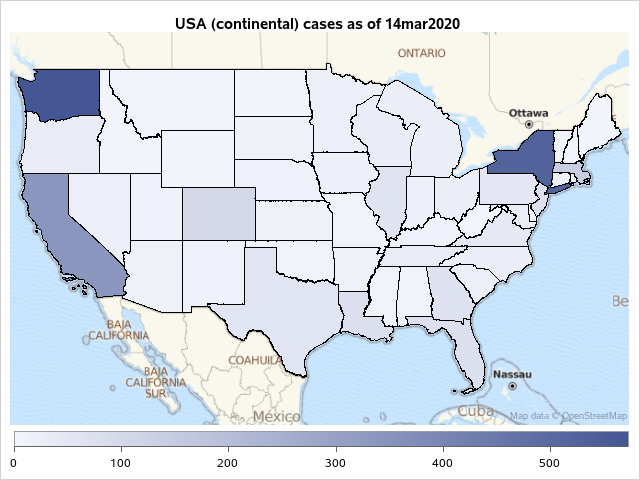
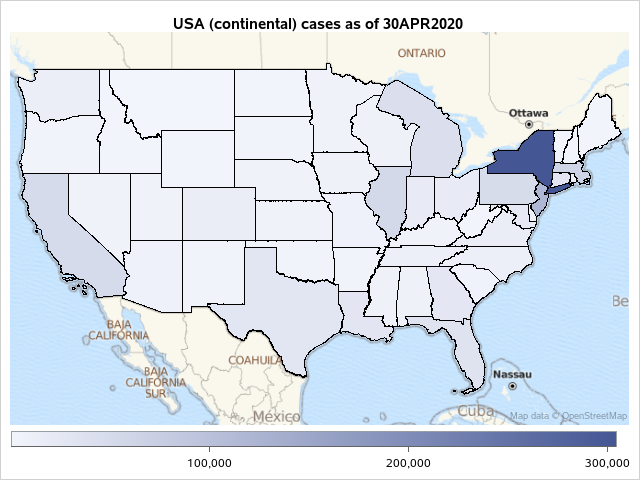

In [3]:
/* max date for these records */
proc sql noprint;
 select max(date) format=date9. into: asOf
  from covid19_jhu_final;
quit;

title;
options nocenter;
ods html5(id=saspy_internal) gtitle;
ods layout gridded columns=2;
ods region;
/* Map of mid-March */
title "USA (continental) cases as of 14mar2020";
proc sgmap
 mapdata=us_state
 maprespdata=covid19_jhu_final
 (where=(country = "United States" and state not in ("Recovered","Alaska","Hawaii") and date="14MAR2020"d));
 openstreetmap ;
 format confirmed_total comma12.;
 choromap confirmed_total / mapid=state legendlabel="# Cases as of 14Mar2020";
run;

ods region;
/* and latest */
title "USA (continental) cases as of &asof.";
proc sgmap
 mapdata=us_state
 maprespdata=covid19_jhu_final
  (where=(country = "United States" and state not in ("Recovered","Alaska","Hawaii") and date="&asOf."d));
 openstreetmap ;
 format confirmed_total comma12.;
 choromap confirmed_total / mapid=state legendlabel="# Cases as of &asof.";
run;
ods layout end;
title;